In [1]:
import os
from pathlib import Path

import copy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from exputils.math.fwht import FWHT
from exputils.cover_states import make_cover_info
from exputils.actual_Amat import generators_to_Amat
from exputils.stabilizer_group import idx_to_pauli_str
from _common import make_custom_cmap

sns.set_theme("paper")
rc = {"mathtext.fontset": "stix"}
plt.rcParams.update(rc)
sns.set(font="Times New Roman")
cmap = make_custom_cmap()

In [2]:
n_qubit = 2
rho_vec = (np.array(range(4**n_qubit)[::-1]) / (4**n_qubit)) * 2 - 1
cover_generators, cover_idxs, cover_vals = copy.deepcopy(make_cover_info(n_qubit))
idxs = [1, 2, 0, 4, 3]
cover_generators = [cover_generators[i] for i in idxs]
cover_idxs = [cover_idxs[i] for i in idxs]
cover_vals = [cover_vals[i] for i in idxs]
coeffs = np.array(
    [
        FWHT(n_qubit, rho_vec[cover_idxs[i]] * cover_vals[i])
        for i in range(len(cover_generators))
    ]
)
coeffs = np.array(coeffs).reshape(-1)
RoM = np.sum(np.abs(coeffs))
Amat = generators_to_Amat(n_qubit, cover_generators)

make_cover_info:   0%|          | 0/5 [00:00<?, ?it/s]

generators_to_Amat:   0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
import matplotlib.colors


def categorical_cmap(nc, nsc, cmap="tab10", continuous=False):
    if nc > plt.get_cmap(cmap).N:
        raise ValueError("Too many categories for colormap.")
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0, 1, nc))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
    cols = np.zeros((nc * nsc, 3))
    for i, c in enumerate(ccolors):
        chsv = matplotlib.colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv, nsc).reshape(nsc, 3)
        arhsv[:, 1] = np.linspace(chsv[1], 0.25, nsc)
        arhsv[:, 2] = np.linspace(chsv[2], 1, nsc)
        rgb = matplotlib.colors.hsv_to_rgb(arhsv)
        cols[i * nsc : (i + 1) * nsc, :] = rgb
    return cols


tab = categorical_cmap(5, 4)

In [4]:
def imshow_Amat(
    Amat,
    rho_vec,
    coeff,
    n_qubit,
    idxs=list(range(4**n_qubit)),
    gen_idx: int = -1,
    title: str = None,
    given_vmin=-np.inf,
    given_vmax=np.inf,
    minus_rho=None,
):
    sz = 5.0
    fig = plt.figure(figsize=(1 + sz * Amat.shape[1] / Amat.shape[0], sz + 1))

    spec = gridspec.GridSpec(
        ncols=2,
        nrows=2,
        width_ratios=[sz * Amat.shape[1] / Amat.shape[0], 1],
        height_ratios=[sz, 1],
        wspace=0.2,
        hspace=None if gen_idx == -1 else 0.3,
    )

    ax0 = fig.add_subplot(spec[0])
    if type(Amat) != np.ndarray:
        A = Amat.toarray().astype(np.float64)
    else:
        A = Amat.astype(np.float64)
    A[A == 0] = np.nan
    sns.heatmap(A, cbar=False, cmap=cmap, ax=ax0)
    ax0.set_yticks(0.5 + np.arange(len(idxs)))
    ax0.set_yticklabels(
        [idx_to_pauli_str(n_qubit, i) for i in idxs],
        rotation=0,
        fontsize=15 if gen_idx == -1 else 30,
        fontfamily="monospace",
    )
    ax0.set_xticks([])
    ax0.set_xlabel(
        "$A$ matrix" + (" (cover matrix)" if gen_idx == -1 else " ($H_n$)"),
        fontsize=25 if gen_idx == -1 else 40,
    )

    ax1 = fig.add_subplot(spec[1])

    # getColorMap
    from matplotlib.colors import LinearSegmentedColormap

    color_list = [
        (0 / 16, tab[8 + 3]),
        (1 / 16, tab[16 + 2]),
        (2 / 16, tab[12 + 2]),
        (3 / 16, tab[8 + 1]),
        (4 / 16, tab[12 + 1]),
        (5 / 16, tab[4 + 3]),
        (6 / 16, tab[16 + 3]),
        (7 / 16, tab[4 + 1]),
        (8 / 16, tab[16 + 1]),
        (9 / 16, tab[12 + 3]),
        (10 / 16, tab[0 + 3]),
        (11 / 16, tab[0 + 1]),
        (12 / 16, tab[8 + 2]),
        (13 / 16, tab[4 + 2]),
        (14 / 16, tab[0 + 2]),
        (15 / 16, "#aaaaaa"),
        (16 / 16, "#aaaaaa"),
    ]
    if gen_idx != -1:
        color_list[-2] = (15 / 16, tab[4 * gen_idx])
        color_list[-1] = (16 / 16, tab[4 * gen_idx])
    cmap_for_rho = LinearSegmentedColormap.from_list("myCmap", color_list)
    sns.heatmap(
        rho_vec[:, np.newaxis],
        cbar=False,
        cmap=cmap_for_rho,
        vmin=-1,
        vmax=1,
        ax=ax1,
    )

    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_xlabel(
        "$b$" if gen_idx == -1 else f"$b_{gen_idx + 1}$",
        fontsize=25 if gen_idx == -1 else 30,
    )
    ax1.text(
        0.5,
        0.5,
        "1.0" if gen_idx == -1 else f"{1/len(cover_generators)}",
        ha="center",
        va="center",
        color="black",
        fontsize=15 if gen_idx == -1 else 30,
    )
    if minus_rho is not None:
        for idx in minus_rho:
            ax1.text(
                0.5,
                idx + 0.5,
                r"$\times-1$",
                ha="center",
                va="center",
                color="black",
                fontsize=15 if gen_idx == -1 else 20,
            )

    ax2 = fig.add_subplot(spec[2])
    sns.heatmap(
        coeff[np.newaxis, :],
        cmap="gray",
        vmin=-5,
        vmax=5,
        cbar=False,
        ax=ax2,
    )
    if gen_idx == -1:
        for i in range(0, coeff.shape[0] // (2**n_qubit)):
            ax2.text(
                (i + 1 / 2) * (2**n_qubit),
                0.5,
                f"$x_{i+1}$",
                ha="center",
                va="center",
                color="w",
                fontsize=25,
            )
    else:
        ax2.text(
            2 ** (n_qubit - 1),
            0.5,
            f"$x_{gen_idx+1}$",
            ha="center",
            va="center",
            color="w",
            fontsize=30,
        )
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xlabel("coefficients", fontsize=25 if gen_idx == -1 else 40)

    plt.tight_layout()
    plt.savefig(
        os.path.join(
            Path().resolve(),
            f"FWHT_{title}_{gen_idx}.png" if gen_idx != -1 else f"FWHT_{title}.png",
        ),
        bbox_inches="tight",
        dpi=500,
    )
    plt.show()

C:\Users\hirok\AppData\Local\Temp\ipykernel_14740\3197253875.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


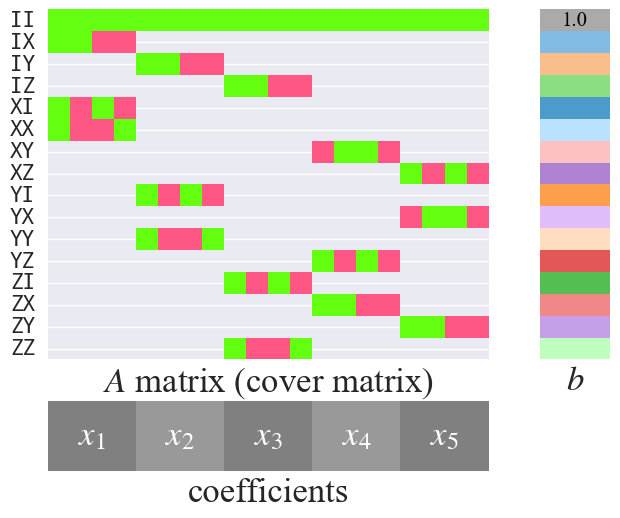

In [5]:
imshow_Amat(
    Amat,
    rho_vec,
    np.array(sum([[i % 2] * (2**n_qubit) for i in range(len(cover_generators))], [])),
    n_qubit,
    title="1",
)

[array([0, 4, 1, 5]), array([ 0,  8,  2, 10]), array([ 0, 12,  3, 15]), array([ 0, 11, 13,  6]), array([ 0,  7, 14,  9])] [array([0.2, 1. , 1. , 1. ]), array([0.2, 1. , 1. , 1. ]), array([0.2, 1. , 1. , 1. ]), array([ 0.2,  1. ,  1. , -1. ]), array([ 0.2,  1. ,  1. , -1. ])]


C:\Users\hirok\AppData\Local\Temp\ipykernel_14740\3197253875.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


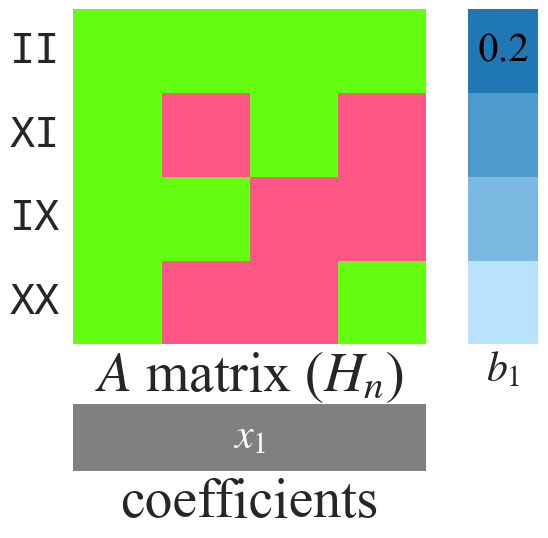

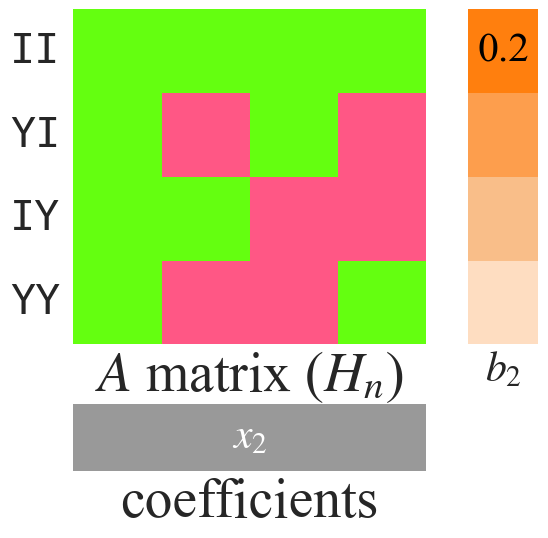

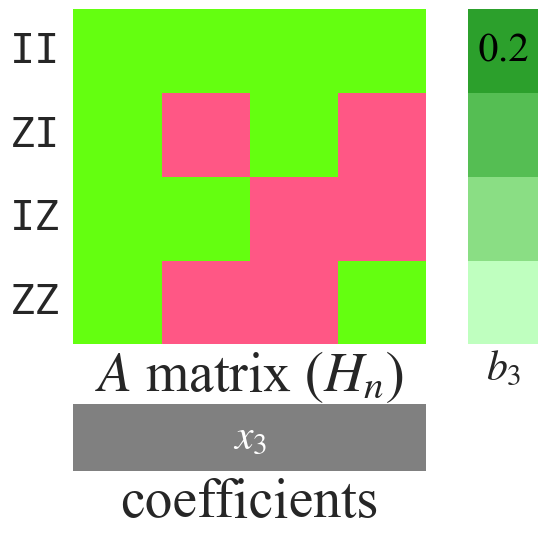

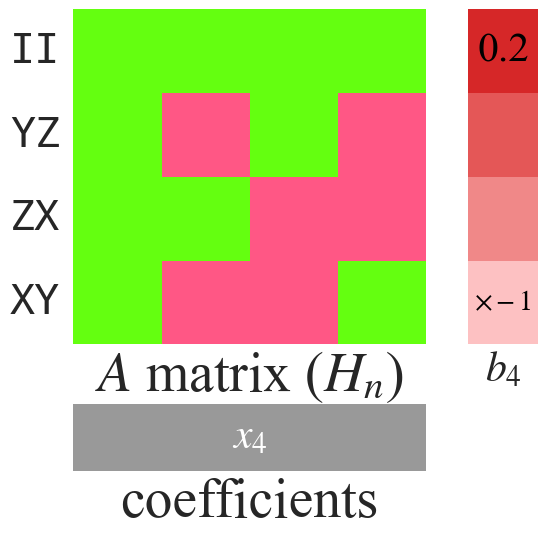

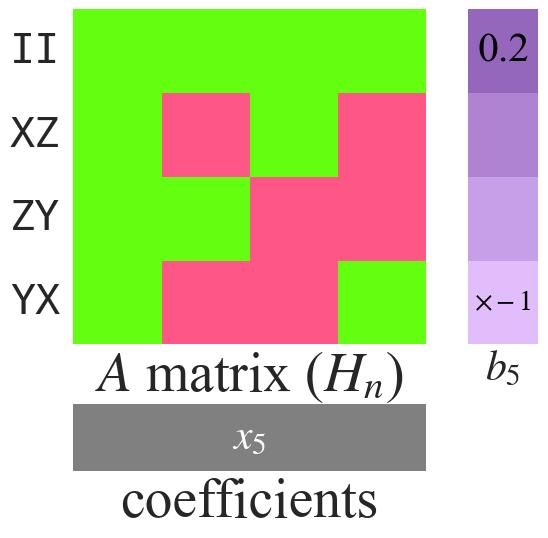

In [6]:
print(cover_idxs, cover_vals)
print("=" * 10)
for i, (cover_idx, cover_val) in enumerate(zip(cover_idxs, cover_vals)):
    small_Amat = Amat[
        cover_idx, i * (2**n_qubit) : (i + 1) * (2**n_qubit)
    ].toarray() * np.array(
        [[int(val > 0) * 2 - 1] * (2**n_qubit) for val in cover_val]
    )
    small_rho_vec = rho_vec[cover_idx]
    small_coeff = np.array([i % 2] * (2**n_qubit))
    imshow_Amat(
        small_Amat,
        small_rho_vec,
        small_coeff,
        n_qubit,
        idxs=cover_idx,
        gen_idx=i,
        title="2",
        minus_rho=[idx for idx, val in enumerate(cover_val) if val < 0],
    )

In [7]:
from PIL import Image


def combine(title: str):
    sns.reset_orig()

    images = [Image.open(f"FWHT_{title}_{i}.png") for i in range(5)]

    dst = Image.new("RGB", (images[0].width * 3, images[0].height * 2))
    dst.paste((255, 255, 255), [0, 0, dst.size[0], dst.size[1]])
    dst.paste(images[0], (0, 0))
    dst.paste(images[1], (images[0].width, 0))
    dst.paste(images[2], (2 * images[0].width, 0))
    dst.paste(images[3], (0, images[0].height))
    dst.paste(images[4], (images[0].width, images[0].height))
    dst.save(f"FWHT_{title}.png")

    for i in range(5):
        os.remove(f"FWHT_{title}_{i}.png")

In [8]:
combine("2")

In [ ]:
def combine_final():
    sns.reset_orig()

    images = [Image.open(f"FWHT_{i}.png") for i in range(1, 2 + 1)]

    images[1] = images[1].resize(
        (images[1].width * images[0].height // images[1].height, images[0].height)
    )

    assert images[0].width < images[1].width

    dst = Image.new("RGB", (2 * images[1].width - 800, images[1].height + 150))
    dst.paste((255, 255, 255), [0, 0, dst.size[0], dst.size[1]])
    dst.paste(images[0], (0, 150))
    dst.paste(images[1], (images[1].width - 800, 150))
    dst.save(f"FWHT.png")


combine_final()

In [ ]:
os.remove("FWHT_1.png")
os.remove("FWHT_2.png")